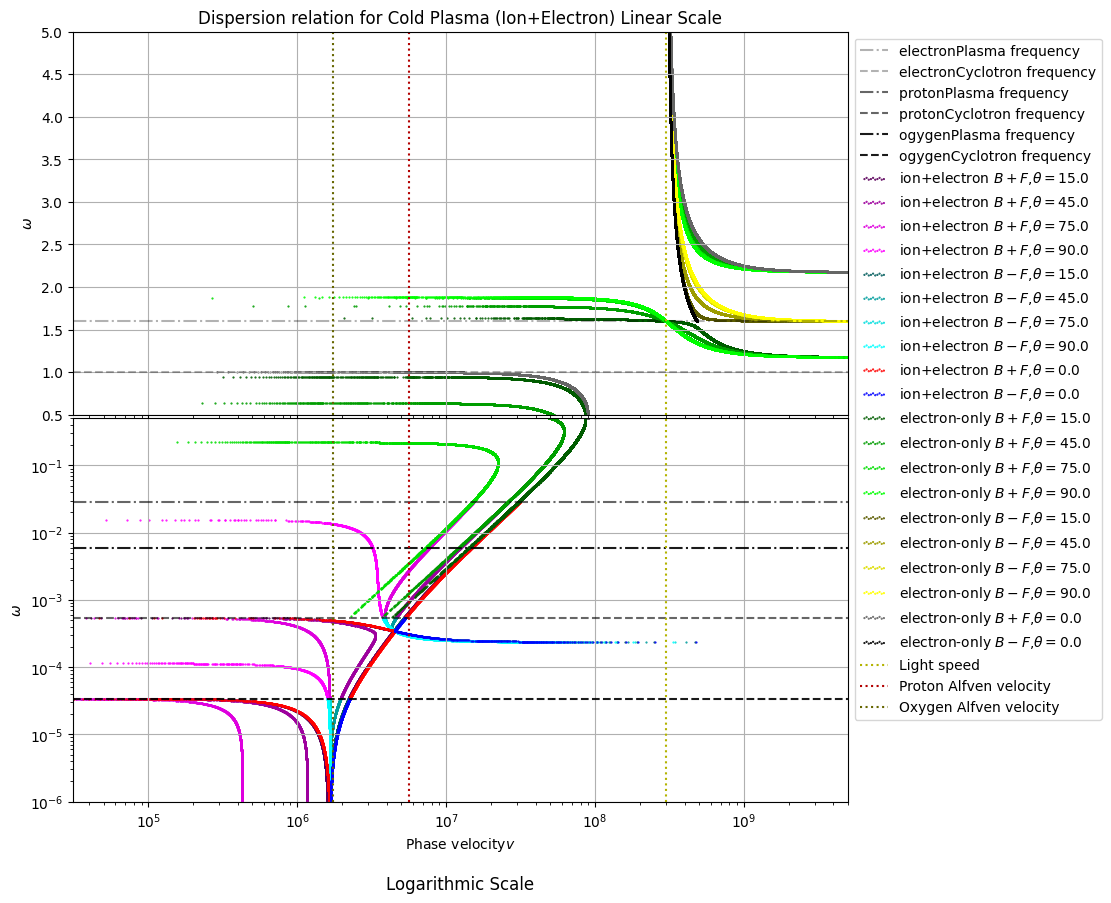

In [5]:
import numpy as np
import matplotlib.pyplot as plt
# 並列化用ライブラリ、引数操作用ライブラリをインポート
import multiprocessing
from functools import partial

#質量
#プラズマ周波数(電子のサイクロトロン周波数で規格化)
#サイクロトロン周波数(電子のサイクロトロン周波数で規格化)
# Constants
c = 3e8
me = 9.1093837015e-31
mh = 1.67262192e-27
a = 0.6 # proton and oxygen ratio

# Initialize plasma parameters
def init_plasma_params():
    oe, pe = 1.0, 1.6
    protons = {
        "mass": mh,
        "charge_sign": 1.0,
        "Cyclotron_freq": oe * me / mh,
        "Plasma_freq": pe * np.sqrt(a * me / mh),
        "name":"proton"
    }
    oxygens = {
        "mass": mh * 16,
        "charge_sign": 1.0,
        "Cyclotron_freq": oe * me / (mh * 16),
        "Plasma_freq": pe * np.sqrt((1.0 - a) * me / (mh * 16)),
        "name":"ogygen"
    }
    electrons = {
        "mass": me,
        "charge_sign": -1.0,
        "Cyclotron_freq": oe,
        "Plasma_freq": pe,
        "name": "electron"
    }
    return {"electron": electrons, "proton": protons, "oxygen": oxygens}

elements = init_plasma_params()

if("electron" in elements):
  electron_plasma_freq = elements["electron"]["Plasma_freq"]
  electron_plasma_cycltrons = elements["electron"]["Cyclotron_freq"]
if("proton" in elements):
  proton_plasma_freq = elements["proton"]["Plasma_freq"]
  proton_plasma_cycltrons = elements["proton"]["Cyclotron_freq"]


linear_graph_max = 5.0
linear_graph_min = 0.5
log_graph_max = linear_graph_min
log_graph_min = 10**-6.0
if("proton" in elements):
  electron_range_max = linear_graph_max
  electron_range_min = proton_plasma_cycltrons
  ions_range_max = proton_plasma_freq
  ions_range_min = log_graph_min
else:
  electron_range_max = linear_graph_max
  electron_range_min = log_graph_min
  ions_range_max = log_graph_max
  ions_range_min = log_graph_min


def filter_arrays(sorted_w, sorted_kp, scale_factor,ratio):

    # x軸方向で隣接する要素間の差を計算(logで)
    differences = np.diff(np.log10(sorted_kp))

    # 刻み幅の閾値を計算（scale_factorをそのまましきい値とする。）
    threshold = scale_factor

    # 閾値以下もしくは8の倍数インデックスを持つ要素のインデックスを取得
    valid_indices = [i for i, diff in enumerate(differences, 1) if diff > threshold or i % 4 == 0]

    # 有効な要素のみを抽出
    filtered_w = sorted_w[valid_indices]
    filtered_kp = sorted_kp[valid_indices]

    return filtered_w, filtered_kp

# 分散関係の計算を関数化
def calc_disp(theta,w,only_electron):

  R = np.ones(w.shape[0])
  L = np.ones(w.shape[0])
  P = np.ones(w.shape[0])

  #電子のみか否かをここで判定
  if only_electron:
     plasma_frequencies = elements["electron"]["Plasma_freq"]
     plasma_cycltrons = elements["electron"]["Cyclotron_freq"]
     charge_sign = elements["electron"]["charge_sign"]
     R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
     L += -plasma_frequencies**2/(w*(w-plasma_cycltrons*charge_sign))
     P += -plasma_frequencies**2/(w*w)
  else:
    for element in elements.values():
      plasma_frequencies = element["Plasma_freq"]
      plasma_cycltrons = element["Cyclotron_freq"]
      charge_sign = element["charge_sign"]
      R += -plasma_frequencies**2/(w*(w+plasma_cycltrons*charge_sign))
      L += -plasma_frequencies**2/(w*(w-plasma_cycltrons*charge_sign))
      P += -plasma_frequencies**2/(w*w)

  S = (R+L)/2

  A = S*np.sin(theta)**2+P*np.cos(theta)**2
  B = R*L*np.sin(theta)**2+P*S*(1+np.cos(theta)**2)
  C = P*R*L
  F = np.sqrt(B**2-4*A*C)
  n2p = (B+F)/(2*A)  #複合プラス
  n2m = (B-F)/(2*A)  #複合マイナス

  #k=の形にする #Nanは一旦Nanのまま
  with np.errstate(invalid='ignore'):
      kpp = w / c * np.sqrt(n2p)
      kmp = w / c * np.sqrt(n2m)

  # 一応負の値も削除
  # Nanを排除
  non_nan_neg_kpp_indices = np.where((~np.isnan(kpp)) & (kpp > 0))[0]
  non_nan_neg_kmp_indices = np.where((~np.isnan(kmp)) & (kmp > 0))[0]
  v_p = w / kpp
  v_m = w / kmp

  # NaNと負の値がない要素のみで配列をフィルタリング
  nan_filtered_v_p = v_p[non_nan_neg_kpp_indices]
  nan_filtered_v_m = v_m[non_nan_neg_kmp_indices]
  nan_filtered_pw = w[non_nan_neg_kpp_indices]

  nan_filtered_mw = w[non_nan_neg_kmp_indices]

  # 波数順になるように並び替える。
  sorted_indices = np.argsort(nan_filtered_v_p)
  sorted_pw = nan_filtered_pw[sorted_indices]
  sorted_v_p = nan_filtered_v_p[sorted_indices]

  sorted_indices = np.argsort(nan_filtered_v_m)
  sorted_mw = nan_filtered_mw[sorted_indices]
  sorted_v_m = nan_filtered_v_m[sorted_indices]

  filtered_pw, filtered_v_p = sorted_pw,sorted_v_p
  filtered_mw, filtered_v_m = sorted_mw,sorted_v_m

  for i in range(2):
    filtered_pw, filtered_v_p = filter_arrays(filtered_pw,filtered_v_p,0.0025,i)
    filtered_mw, filtered_v_m = filter_arrays(filtered_mw,filtered_v_m,0.0025,i)


  return [filtered_v_p,filtered_v_m, filtered_pw, filtered_mw, theta]


# イオンを実行
if not (("electron" in elements) and len(elements)==1):
  wlog =  np.logspace(np.log10(ions_range_min), np.log10(ions_range_max), 10**5) # 対数の配列も生成
  w = wlog
  if(ions_range_max>linear_graph_min):
    w = np.arange(linear_graph_min,ions_range_max,10**-6)  #変数は周波数
    w = np.concatenate((w, wlog)) # 上の2つの配列を結合
    
  thetas = [0,np.pi/12,np.pi/4,np.pi/2.4,np.pi/2]

  # イオンについてシータを並列化して処理を実行
  pool = multiprocessing.Pool()
  partial_func = partial(calc_disp, w=w, only_electron = False) # wは並列化しないための指示
  results_ion = pool.map(partial_func, thetas)
  pool.close()
  pool.join()


# 電子のみを実行
if("electron" in elements):
  w = np.arange(electron_range_min,linear_graph_max,10**-6)  #変数は周波数
  if(electron_range_max<log_graph_min):
    wlog =  np.logspace(np.log10(electron_range_min), np.log10(log_graph_max), 10**5) # 対数の配列も生成
    w = np.concatenate((w, wlog)) # 上の2つの配列を結合

  thetas = [0,np.pi/12,np.pi/4,np.pi/2.4,np.pi/2]

  # 電子についてシータを並列化して処理を実行

  pool = multiprocessing.Pool()
  partial_func = partial(calc_disp, w=w, only_electron = True) # wは並列化しないための指示
  results_electron = pool.map(partial_func, thetas)
  pool.close()
  pool.join()



# 2つのグラフを描画

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

ax1.set_xscale('log')
ax1.set_title('Dispersion relation for Cold Plasma (Ion+Electron) Linear Scale')
ax1.grid(True)
ax1.set_ylim(linear_graph_min,linear_graph_max)

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Logarithmic Scale', y = -0.25)
ax2.grid(True)
ax2.set_ylim(log_graph_min,log_graph_max)


# 描画

# 描画関数
def plot_disp(results, w, colors, ax, source):

    for i in [1,0]: # kpp & kmp
      # 配列結合は効果なさそうだったのでやめた。
      for result in results: # 各thetaごとに
        theta = result[4]
        color = colors[i]
        colorpower = ((theta/(np.pi/2))+0.3)/1.3
        if(theta != 0):
           if(color == 'cyan'):
              color = (0,colorpower,colorpower)
           if(color == 'magenta'):
              color = (colorpower,0,colorpower)
           if(color == 'yellow'):
              color = (colorpower,colorpower,0)
           if(color == 'green'):
              color = (0,colorpower,0)
        if(i == 0):
          ax.scatter(result[i], result[i+2], color=color, s= 0.3, label=source + " " + r'$B-F$,$\theta=$'+str(theta/np.pi*180))
        else:
          ax.scatter(result[i], result[i+2], color=color, s= 0.3, label=source + " " + r'$B+F$,$\theta=$'+str(theta/np.pi*180))

count = 0
for element in elements.values():
  plasma_frequencies = element["Plasma_freq"]
  plasma_cycltrons = element["Cyclotron_freq"]
  count += 1
  ax1.axhline(y=plasma_frequencies,linestyle='dashdot',alpha=0.3*count,color='k',label=element['name']+'Plasma frequency')
  ax1.axhline(y=plasma_cycltrons,linestyle='dashed',alpha=0.3*count,color='k',label=element['name']+'Cyclotron frequency')
  ax2.axhline(y=plasma_frequencies,linestyle='dashdot',alpha=0.3*count,color='k',label=element['name']+'Plasma frequency')
  ax2.axhline(y=plasma_cycltrons,linestyle='dashed',alpha=0.3*count,color='k',label=element['name']+'Cyclotron frequency')


color_map = {'theta_0': ('blue', 'red'), 'theta_not_0': ('cyan', 'magenta')}

# 内包リストを使って、result[4]←theta が0のリストとそれを省いたリストを生成。
if not (("electron" in elements) and len(elements)==1):
  plot_disp([result for result in results_ion if result[4] != 0], w, color_map['theta_not_0'], ax1, 'ion+electron')
  plot_disp([result for result in results_ion if result[4] == 0], w, color_map['theta_0'], ax1, 'ion+electron')
  plot_disp([result for result in results_ion if result[4] != 0], w, color_map['theta_not_0'], ax2, 'ion+electron')
  plot_disp([result for result in results_ion if result[4] == 0], w, color_map['theta_0'], ax2, 'ion+electron')

color_map = {'theta_0': ('black', '0.4'), 'theta_not_0': ('yellow', 'green')}

# 内包リストを使って、result[4]←theta が0のリストとそれを省いたリストを生成。
if("electron" in elements):
  plot_disp([result for result in results_electron if result[4] != 0], w, color_map['theta_not_0'], ax1, 'electron-only')
  plot_disp([result for result in results_electron if result[4] == 0], w, color_map['theta_0'], ax1, 'electron-only')
  plot_disp([result for result in results_electron if result[4] != 0], w, color_map['theta_not_0'], ax2, 'electron-only')
  plot_disp([result for result in results_electron if result[4] == 0], w, color_map['theta_0'], ax2, 'electron-only')





plt.xlim(3.1e4,5.0e9)


lightcol = (0.7,0.7,0.0)

ax1.axvline(x=c,linestyle='dotted',alpha=1.0,color=lightcol,label='Light speed')
ax2.axvline(x=c,linestyle='dotted',alpha=1.0,color=lightcol,label='Light speed')

if("proton" in elements):
  proton_alfven_vel_color = (0.7,0.0,0.0)
  proton_alfven_vel = c*elements["proton"]["Cyclotron_freq"]/elements["proton"]["Plasma_freq"]
  ax1.axvline(x=proton_alfven_vel,linestyle='dotted',alpha=1.0,color=proton_alfven_vel_color,label='Proton Alfven velocity')
  ax2.axvline(x=proton_alfven_vel,linestyle='dotted',alpha=1.0,color=proton_alfven_vel_color,label='Proton Alfven velocity')
if("oxygen" in elements):
  oxygen_vel_color = (0.4,0.4,0.0)
  oxygen_alfven_vel = c*elements["oxygen"]["Cyclotron_freq"]/elements["oxygen"]["Plasma_freq"]
  ax1.axvline(x=oxygen_alfven_vel,linestyle='dotted',alpha=1.0,color=oxygen_vel_color,label='Oxygen Alfven velocity')
  ax2.axvline(x=oxygen_alfven_vel,linestyle='dotted',alpha=1.0,color=oxygen_vel_color,label='Oxygen Alfven velocity')

ax1.legend(scatterpoints=10, loc='upper left', bbox_to_anchor=(1, 1))
#ax2.legend(scatterpoints=10,loc='upper left', bbox_to_anchor=(1, 1))
ax2.set_xlabel("Phase velocity" + r'$v$')
ax1.set_ylabel(r'$\omega$')
ax2.set_ylabel(r'$\omega$')
fig.subplots_adjust(hspace=0.01)
